<center>
<h1> Comparaison des méthodes de screening pour le problème LASSO 


In [1]:
#Importation des modules necessaires
from sklearn import linear_model
from src.screening_rules import *
from src.gen_data import *
import time
import matplotlib.pyplot as plt
import pandas as pd

## Préambule

Pour comparer les différentes méthodes de screening pour la résolution du problème LASSO, nous implémentons une fonction ``test_method`` qui prend en paramètre :
* les données du problème X et y
* une liste décroissante de paramètres de régularisation λ
* une tolérance pour les méthodes de screening
Celle-ci renvoie les temps d'execution pour chaque méthode ainsi que le nombre de variables éliminés avant la résolution du problème LASSO. Voici son implémentation : 

In [10]:
def test_method(X,y,λ, tol = 10**(-9),verbose=False):
    β=np.zeros(X.shape[1])

    Tsasvi=[]
    Tnormal=[]
    Tstrong=[]
    Tsafe=[]

    nb_removed_sasvi=[]
    nb_removed_strong=[]
    nb_removed_safe=[]
    nb_removed_lasso=[]

    for i in range(len(λ)-1):
        if(verbose):
            print("#### Step n°{}/{} ####".format(i+1,len(λ)-1))

        θ1star=(y-np.dot(X,β))/λ[i]
        a=get_parameter(y, λ[i], θ1star)
        b=get_parameter(y, λ[i+1], θ1star)
        
        #SASVI SCREENING AND FITTING
        start=time.time()
        to_drop_sasvi=sasvi(X,y,a,b,λ[i],λ[i+1], θ1star, tol=tol)
        tmp_time=(time.time()-start)

        X_sasvi = np.delete(X, to_drop_sasvi, 1)
        nb_removed_sasvi.append(np.shape(to_drop_sasvi)[1])
        if(verbose):
            print("Number of variables removed with sasvi :",np.shape(to_drop_sasvi)[1])

        start=time.time()
        if X_sasvi.shape[1] != 0:
            clf = linear_model.Lasso(alpha=λ[i+1]/X.shape[0],fit_intercept=False,max_iter=2000)
            clf.fit(X_sasvi,y)
        Tsasvi.append(tmp_time+time.time()-start)

        #STRONG RULE SCREENING AND FITTING
        to_drop_strong=strong_rule(X,θ1star, λ[i], λ[i+1], tol=tol)
        X_strong = np.delete(X, to_drop_strong, 1)
        nb_removed_strong.append(np.shape(to_drop_strong)[1])
        if(verbose):
            print("Number of variables removed with strong rule :",np.shape(to_drop_strong)[1])

        start=time.time()
        if X_strong.shape[1] != 0:
            clf = linear_model.Lasso(alpha=λ[i+1]/X.shape[0],fit_intercept=False,max_iter=2000)
            clf.fit(X_strong,y)
        Tstrong.append(time.time()-start)

        #SAFE RULE SCREENING AND FITTING
        to_drop_safe=safe_screening(X,y,λ[i], λ[i+1], tol=tol)
        X_safe = np.delete(X, to_drop_safe, 1)
        nb_removed_safe.append(np.shape(to_drop_safe)[1])
        if(verbose):
            print("Number of variables removed with safe rule :",np.shape(to_drop_safe)[1])

        start=time.time()
        if X_safe.shape[1] != 0:
            clf = linear_model.Lasso(alpha=λ[i+1]/X.shape[0],fit_intercept=False,max_iter=2000)
            clf.fit(X_safe,y)
        Tsafe.append(time.time()-start)


        #NO SCREENING FITTING  
        start=time.time()
        clf = linear_model.Lasso(alpha=λ[i+1]/X.shape[0],fit_intercept=False,max_iter=2000)
        clf.fit(X,y)
        Tnormal.append(time.time()-start)
        β=clf.coef_
        nb_removed_lasso.append(np.sum(np.abs(β) < tol)) 
        if(verbose):
            print("Number of variables removed exactly :",nb_removed_lasso[-1])
        
    return(Tsasvi,Tnormal,Tstrong,Tsafe,nb_removed_sasvi,nb_removed_strong,nb_removed_safe, nb_removed_lasso)

Nous implémentons aussi la fonction ``plot_res`` pour visualiser les sorties de la fonction précédente. Voici son implémentation : 

In [3]:
def plot_res(Tsasvi,Tnormal,Tstrong,Tsafe,nb_removed_sasvi,nb_removed_strong,nb_removed_safe,nb_removed_lasso, λ, λ_max, p):

    plt.figure(figsize=(12,8))
    plt.plot(λ[list(range(1,len(Tnormal)+1))]/λ_max,Tnormal,label='Normal')
    plt.plot(λ[list(range(1,len(Tnormal)+1))]/λ_max,Tsasvi,label='Sasvi')
    plt.plot(λ[list(range(1,len(Tnormal)+1))]/λ_max,Tstrong,label='Strong')
    plt.plot(λ[list(range(1,len(Tnormal)+1))]/λ_max,Tsafe,label='Safe')
    plt.legend()
    plt.xlabel("λ/λ_max")
    plt.ylabel("Time")
    plt.title("Time to compute as a function of λ/λ_max")

    plt.figure(figsize=(12,8))
    plt.plot(λ[list(range(1,len(Tnormal)+1))]/λ_max,np.array(nb_removed_lasso)/p,label='(Exact) Nb null coefficients',linestyle="dashed")
    plt.plot(λ[list(range(1,len(Tnormal)+1))]/λ_max,np.array(nb_removed_sasvi)/p,label='Sasvi')
    plt.plot(λ[list(range(1,len(Tnormal)+1))]/λ_max,np.array(nb_removed_strong)/p,label='Strong')
    plt.plot(λ[list(range(1,len(Tnormal)+1))]/λ_max,np.array(nb_removed_safe)/p,label='Safe')
    plt.legend()
    plt.xlabel("λ/λ_max")
    plt.ylabel("Nb removed/Total nb of variables")
    plt.title("Proportion of removed variables as a function of λ/λ_max")

## Application à la base de données MNIST

Nous générons les données de MNIST (cf rapport pour détails).

In [4]:
[X,y]=gen_data_MNIST()
p=len(X[1,:])
λ_max=np.max(np.abs(np.dot(y,X)))
λ=np.linspace(1,0.05,100)*λ_max

Nous comparons ensuite les différentes méthodes de screening : 

#### Step n°1/99 ####
Number of variables removed with sasvi : 49998
Number of variables removed with strong rule : 49998
Number of variables removed with safe rule : 49998
Number of variables removed exactly : 49999
#### Step n°2/99 ####
Number of variables removed with sasvi : 50000
Number of variables removed with strong rule : 49998
Number of variables removed with safe rule : 49998
Number of variables removed exactly : 49999
#### Step n°3/99 ####
Number of variables removed with sasvi : 50000
Number of variables removed with strong rule : 49998
Number of variables removed with safe rule : 49998
Number of variables removed exactly : 49999
#### Step n°4/99 ####
Number of variables removed with sasvi : 50000
Number of variables removed with strong rule : 49998
Number of variables removed with safe rule : 49998
Number of variables removed exactly : 49999
#### Step n°5/99 ####
Number of variables removed with sasvi : 50000
Number of variables removed with strong rule : 49998
Number of 

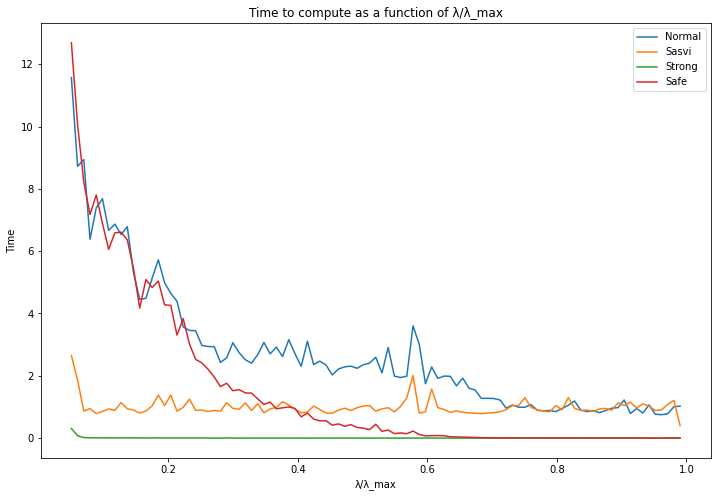

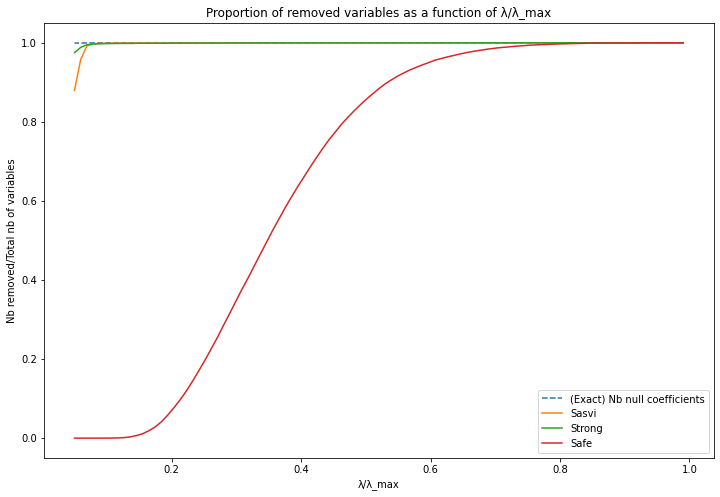

In [5]:
Tsasvi,Tnormal,Tstrong,Tsafe,nb_removed_sasvi,nb_removed_strong,nb_removed_safe, nb_removed_lasso=test_method(X,y, λ, tol=10**(-9),verbose=True)
plot_res(Tsasvi,Tnormal,Tstrong,Tsafe,nb_removed_sasvi,nb_removed_strong,nb_removed_safe,nb_removed_lasso,λ, λ_max,p)

Enfin, nous calculons le temps d'execution global associé à chaque méthode : 

In [6]:
nb_lambda=np.repeat(len(Tsasvi),4)
sumTime=[np.sum(Tsasvi),np.sum(Tnormal),np.sum(Tstrong),np.sum(Tsafe)]
method=["Sasvi","No screening","Strong","Safe approach"]
df=pd.DataFrame({"Method":method,"Nb_lambda":nb_lambda,"MNIST time":sumTime})
df

,Method,Nb_lambda,MNIST time
0,Sasvi,99,98.757521
1,No screening,99,269.113978
2,Strong,99,0.672920
3,Safe approach,99,155.749270


## Application à la base de données PIE

Nous générons les données de PIE (cf rapport pour détails).

In [11]:
[X,y]=gen_data_PIE()
p=len(X[1,:])
λ_max=np.max(np.abs(np.dot(y,X)))
λ=np.linspace(1,0.05,100)*λ_max

Nous comparons ensuite les différentes méthodes de screening : 

#### Step n°1/99 ####
Number of variables removed with sasvi : 11552
Number of variables removed with strong rule : 11552
Number of variables removed with safe rule : 11552
Number of variables removed exactly : 11552
#### Step n°2/99 ####
Number of variables removed with sasvi : 11553
Number of variables removed with strong rule : 11552
Number of variables removed with safe rule : 11550
Number of variables removed exactly : 11552
#### Step n°3/99 ####
Number of variables removed with sasvi : 11553
Number of variables removed with strong rule : 11552
Number of variables removed with safe rule : 11546
Number of variables removed exactly : 11552
#### Step n°4/99 ####
Number of variables removed with sasvi : 11553
Number of variables removed with strong rule : 11552
Number of variables removed with safe rule : 11543
Number of variables removed exactly : 11552
#### Step n°5/99 ####
Number of variables removed with sasvi : 11553
Number of variables removed with strong rule : 11552
Number of 

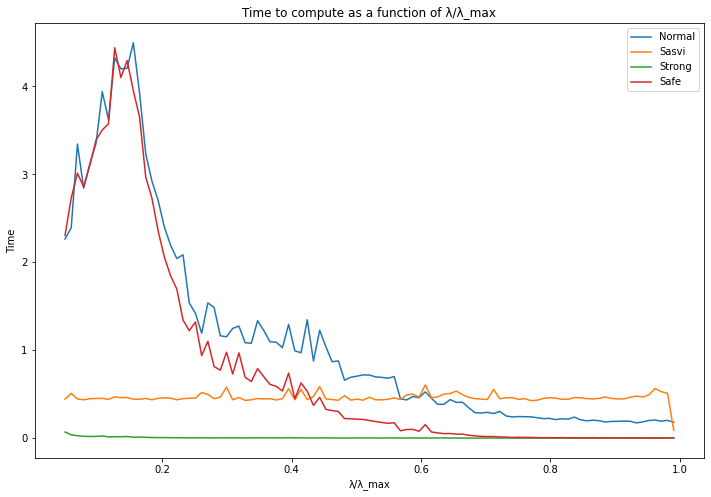

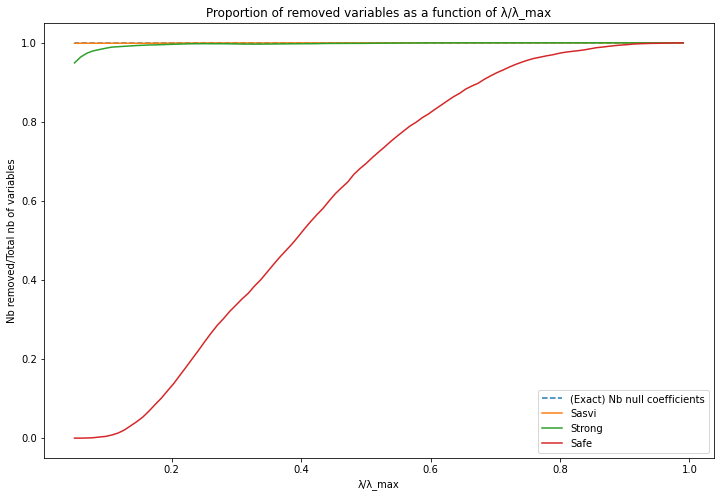

In [12]:
Tsasvi,Tnormal,Tstrong,Tsafe,nb_removed_sasvi,nb_removed_strong,nb_removed_safe, nb_removed_lasso=test_method(X,y, λ, tol=10**(-9),verbose=True)
plot_res(Tsasvi,Tnormal,Tstrong,Tsafe,nb_removed_sasvi,nb_removed_strong,nb_removed_safe,nb_removed_lasso,λ, λ_max,p)

Enfin, nous calculons le temps d'execution global associé à chaque méthode : 

In [13]:
nb_lambda=np.repeat(len(Tsasvi),4)
sumTime=[np.sum(Tsasvi),np.sum(Tnormal),np.sum(Tstrong),np.sum(Tsafe)]
method=["Sasvi","No screening","Strong","Safe approach"]
df=pd.DataFrame({"Method":method,"Nb_lambda":nb_lambda,"PIE time":sumTime})
df

,Method,Nb_lambda,PIE time
0,Sasvi,99,45.695667
1,No screening,99,111.799075
2,Strong,99,0.477193
3,Safe approach,99,80.304896
